In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = "/content/drive/MyDrive/stock"

In [3]:
import yfinance as yf
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import time
import os
import json
import pandas as pd

In [5]:
plt.style.use('fivethirtyeight')


today = datetime.date.today()

ticker = "BBCA.JK"

with open(f'{file_path}/stock.json', 'r') as f:
    jsonStock = json.load(f)
index = None
isExist = True
for i, stock in enumerate(jsonStock['data']):
    if stock['name'] == ticker:
        index = i
        print("a")
        isExist = True
        break
    else:
        print('b')
        isExist = False
if isExist == False:
    jsonStock['data'].append({
        "name": ticker,
        "updated_at": 0,
        "last_file": "",
        "rmse": 0,
        "last_predict": 0
    })
    index = len(jsonStock['data']) - 1

data = yf.download(ticker, start="2010-01-01", end="2024-04-30")

ts = data.iloc[-1].name
lastDate = ts.strftime('%Y-%m-%d')
data['predict'] = 0

dataset = data.filter(['Close'])
if not os.path.exists(f'{file_path}/{ticker}'):
    os.makedirs(f'{file_path}/{ticker}')

valdataset = dataset.values


b
a
[*********************100%***********************]  1 of 1 completed


In [6]:
train_len = math.ceil(len(valdataset) * 0.8)
len_predict = len(valdataset) - train_len

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(valdataset)

print(scaled_data)

train_data = scaled_data[0:train_len]
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape


[[0.01250744]
 [0.01369863]
 [0.01012507]
 ...
 [0.97022037]
 [0.95533055]
 [0.96426444]]


(2584, 60, 1)

In [7]:
def train():
    model = Sequential()
    model.add(LSTM(128, return_sequences=True,
              input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=25, epochs=32, callbacks=[EarlyStopping(monitor='loss', patience=5)])
    
    model.save(f'{file_path}/{ticker}/Model_{ticker}.h5')

    test_data = scaled_data[train_len - 60:, :]
    x_test = []
    y_test = valdataset[train_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predict = model.predict(x_test)
    predict = scaler.inverse_transform(predict)

    return predict, y_test, model

In [9]:
rmse = 9990
while rmse > 20:
    predict, y_test, model = train()
    rmse = np.sqrt(np.mean(predict - y_test)**2)
    print(rmse)

jsonStock['data'][index]['rmse'] = rmse.item()
jsonStock['data'][index]['updated_at'] = math.floor(time.time())
jsonStock['data'][index]['last_file'] = f'{today}.csv'
jsonStock['data'][index]['last_date'] = lastDate

with open(f'{file_path}/stock.json', 'w') as f:
    json.dump(jsonStock, f)

dataset['predict'] = 0

dataset.loc[data.index[-len_predict:], 'predict'] = predict
dataset.to_csv(f'{file_path}/{ticker}/{lastDate}.csv')

train = data[:train_len]
valid = data[train_len:]
valid['predict'] = predict

predict_data = scaled_data[-60:]
predict_data = np.array(predict_data)
prediction = model.predict(predict_data.reshape(1, 60, 1))
prediction = scaler.inverse_transform(prediction)
jsonStock['data'][index]['last_predict'] = prediction
print(prediction)


Epoch 1/32


KeyboardInterrupt: ignored

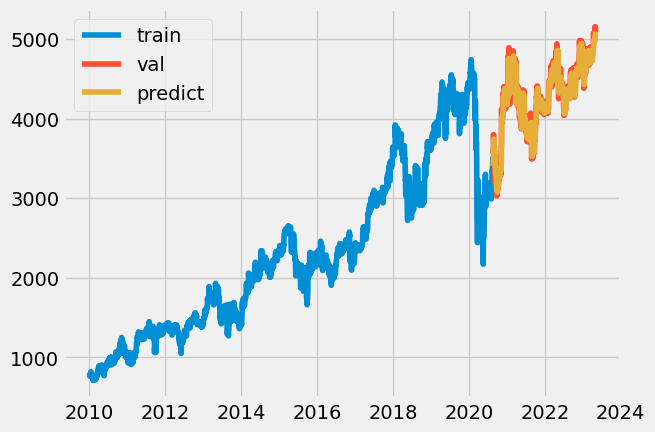

In [ ]:
# print(valid)
plt.figure()
plt.plot(train['Close'])
plt.plot(valid[['Close', 'predict']])
plt.legend(['train', 'val', 'predict'])
plt.show()